# Introduction
In this notebook, I will analyse the success of my most played chess gambits using data from Lichess API.org's API. These are the featured gambits: Vienna, Tennison, Stafford and Jaenisch.

<br>

The dataset contains information not limited to: the frequency a chess opening is played and the total number of times white or black wins in a chess opening. This information can be further filtered by chess elo and game length.

<br>

The goal of this analysis is to see which gambits I should play, based on these factors: 
<ul>
<li> elo of my opponent
<li> game length (bullet: 1min blitz: 3 min/5min, rapid: 10 min)
</ul>


#Overview

1. Data Preparation

* Collecting Data for White Gambits & Black Gambits

  * Utilize the public Lichess API to gather data on selected gambits.
* Load the collected data into Pandas DataFrames for further analysis.

* Data Cleaning / Transformation

  * Eliminate duplicate rows and round win percentages for accuracy.
  * Adjust column names to reflect the corresponding values appropriately.

2. Data Visualization & Analysis

* Visualize win rates against opponent Elo (skill level) for each gambit using line graphs.

  * Identify points where a gambit's win rate drops below 50%.

  * Describe trends in win rates based on varying Elo and game length.
* Plot the average win rates categorized by game length and gambit type using a multi-bar graph.

  * Determine the most favorable gambits to play and those to avoid in each category.

3. Conclusion

* Summarize the key findings derived from the analysis.
* Discuss the implications of the results and their relevance to decision-making.
* Highlight any limitations of the findings and potential areas for further investigation.









# Dataset

The dataset used for this analysis is provided in a JSON format. It consists of the following key-value pairs:
<ul>
<li> <b>white</b>: the number of times white has won from an opening.
<li> <b>draws</b>: the number of times a draw occured from an opening.
<li> <b>black</b>: the number of times black has won from an opening.
<li> <b>moves</b>: a list of moves to play next, accompanied by the average rating of players who have played those moves.
<li> <b>recentGames</b>: a recent list of moves played by lichess players immediately after the opening
<li> <b>opening</b>: the known name for the opening move order
<li> <b>history</b>: a monthly recording of the number of times the opening has been played
</ul>

Below is an example query using a gambit that I will use in the analysis:



In [ ]:
import requests

In [ ]:
url = 'https://explorer.lichess.ovh/lichess?variant=standard&speeds=blitz,rapid,classical&ratings=1000&fen=r1bqkb1r/ppp2ppp/2p2n2/8/4P3/8/PPPP1PPP/RNBQKB1R%20w%20KQkq%20-%200%205&history=true'

response = requests.get(url)
data = response.json()
for key in data:
    value = data[key]
    print(key, ":", value)

white : 204747
draws : 15032
black : 247942
moves : [{'uci': 'b1c3', 'san': 'Nc3', 'averageRating': 1123, 'white': 64174, 'draws': 4730, 'black': 84505, 'game': None}, {'uci': 'd2d3', 'san': 'd3', 'averageRating': 1125, 'white': 47048, 'draws': 3450, 'black': 56179, 'game': None}, {'uci': 'e4e5', 'san': 'e5', 'averageRating': 1118, 'white': 40216, 'draws': 2842, 'black': 40542, 'game': None}, {'uci': 'f1c4', 'san': 'Bc4', 'averageRating': 1115, 'white': 14103, 'draws': 973, 'black': 18768, 'game': None}, {'uci': 'd1e2', 'san': 'Qe2', 'averageRating': 1115, 'white': 11427, 'draws': 889, 'black': 13445, 'game': None}, {'uci': 'f2f3', 'san': 'f3', 'averageRating': 1115, 'white': 7967, 'draws': 648, 'black': 9383, 'game': None}, {'uci': 'f1d3', 'san': 'Bd3', 'averageRating': 1119, 'white': 4252, 'draws': 333, 'black': 8380, 'game': None}, {'uci': 'd2d4', 'san': 'd4', 'averageRating': 1107, 'white': 5459, 'draws': 445, 'black': 5670, 'game': None}, {'uci': 'd1f3', 'san': 'Qf3', 'averageRati

#Utilities

Below are some functions to save time and sanity in constructing the request url's manually:
<li> encode(...) : replaces strings in the input with '%20'
<li> make_url(...): constructs a request url given the variant,speeds,ratings and fen in the input

In [ ]:
def encode(raw_fen: str) -> str:
  result = ""
  for char in raw_fen:
    if char == ' ':
      result += "%20"
    else:
      result += char
  return result

def make_request_url(variant: str, speed: str,rating: str,fen: str) -> str:
  endpoint = 'https://explorer.lichess.ovh/lichess'
  variant_enc = 'variant=' + variant
  speed_enc = 'speeds=' + speed
  rating_enc = 'ratings=' + rating
  fen = 'fen=' + encode(fen)

  url = endpoint + "?" + variant_enc + "&" + speed_enc + "&" + rating_enc + "&" + fen

  return url

#Collecting Data for White Gambits







In [ ]:
#fens in order: vienna, tennison
white_gambit_fens = [
               'rnbqkb1r/pppp1ppp/5n2/4p3/4PP2/2N5/PPPP2PP/R1BQKBNR b KQkq - 0 3',
               'rnbqkbnr/ppp1pppp/8/3p4/4P3/5N2/PPPP1PPP/RNBQKB1R b KQkq - 1 2'
               ]

#fens in order: stafford, jaenisch
black_gambit_fens = [
    'r1bqkb1r/ppp2ppp/2p2n2/8/4P3/8/PPPP1PPP/RNBQKB1R w KQkq - 0 5',
    'r1bqkbnr/pppp2pp/2n5/1B2pp2/4P3/5N2/PPPP1PPP/RNBQK2R w KQkq - 0 4'
]

speeds = [
    'bullet','blitz','rapid'
]
elos = [
    '1000','1200','1400','1600','1800','2000','2200','2500'
]

'''
general structure of dictionary : collected_data
{
  gambit: [
    {elo: 0000 , speed: aaaa , winrate: 0000}
  ]
}
'''

collected_data = {}

#I am going to get the winrates for each opening, in each elo and in each game length, and store them as specified in the comments of the code above
for opening in white_gambit_fens:
  for speed in speeds:
    for elo in elos:
      request_url = make_request_url('standard',speed,elo,opening)
      response_data = requests.get(request_url).json()

      winRate = response_data['white'] / (response_data['black'] + response_data['draws'] + response_data['white'])

      if (response_data['opening']['name'] not in collected_data):
          collected_data[response_data['opening']['name']] = []

      collected_data[response_data['opening']['name']].append({
          'elo':elo,
          'speed':speed,
          'winRate': winRate
      })



# Collecting Data for Black gambits

Divided requests from black and white in order to bypass the 'too many requests' error when coupled together.

In [ ]:
#collect data from black gambits
for opening in black_gambit_fens:
  for speed in speeds:
    for elo in elos:
      request_url = make_request_url('standard',speed,elo,opening)
      response_data = requests.get(request_url).json()

      winRate = response_data['black'] / (response_data['black'] + response_data['draws'] + response_data['white'])

      if (response_data['opening']['name'] not in collected_data):
          collected_data[response_data['opening']['name']] = []

      collected_data[response_data['opening']['name']].append({
          'elo':elo,
          'speed':speed,
          'winRate': winRate
      })



# Data Cleaning/Transformation


In [ ]:
#There is a correct amount of entries for each opening:
# 3 speeds * 8 elos = 24 calculated winRates
# Below are things I would like to change:
# - change winRates to Winrates (%) , elo to Elo and speed to Category
# - change the winRates to whole numbers rounded to its second decimal. i.e 0.59832 -> 59.83
# - remove any duplicates if any (for when requesting data for black gambits too quickly after requesting white gambit data)

for key in collected_data:
  print(key,len(collected_data[key]))

for key in collected_data:
  print(collected_data[key])

Vienna Game: Vienna Gambit 24
Zukertort Opening: Tennison Gambit 24
Russian Game: Stafford Gambit 24
Ruy Lopez: Schliemann Defense 24
[{'elo': '1000', 'speed': 'bullet', 'winRate': 0.5726103558566239}, {'elo': '1200', 'speed': 'bullet', 'winRate': 0.5658409286560815}, {'elo': '1400', 'speed': 'bullet', 'winRate': 0.5692132871561592}, {'elo': '1600', 'speed': 'bullet', 'winRate': 0.5666088367494033}, {'elo': '1800', 'speed': 'bullet', 'winRate': 0.5560933756394483}, {'elo': '2000', 'speed': 'bullet', 'winRate': 0.5329188709116887}, {'elo': '2200', 'speed': 'bullet', 'winRate': 0.5184060195250885}, {'elo': '2500', 'speed': 'bullet', 'winRate': 0.5229601283792125}, {'elo': '1000', 'speed': 'blitz', 'winRate': 0.5792592639666491}, {'elo': '1200', 'speed': 'blitz', 'winRate': 0.5785797460924557}, {'elo': '1400', 'speed': 'blitz', 'winRate': 0.5770373393499303}, {'elo': '1600', 'speed': 'blitz', 'winRate': 0.5715206973615451}, {'elo': '1800', 'speed': 'blitz', 'winRate': 0.5578518377010935},

In [ ]:
#import data into dataframes
import pandas as pd
pd.set_option('display.max_rows',None)

vienna_df = pd.DataFrame(collected_data['Vienna Game: Vienna Gambit'])
tennison_df = pd.DataFrame(collected_data['Zukertort Opening: Tennison Gambit'])
stafford_df = pd.DataFrame(collected_data['Russian Game: Stafford Gambit'])
jaenisch_df = pd.DataFrame(collected_data['Ruy Lopez: Schliemann Defense'])

dfs = [vienna_df,tennison_df,stafford_df,jaenisch_df]

In [ ]:
#cleaning and transforming data
for df in dfs:
  #rename columns
  df.rename(columns={'winRate': 'Winrate (%)','speed':'Category','elo':'Elo'}, inplace=True)
  #get percentages of chess gambits
  df['Winrate (%)'] = round(df['Winrate (%)'] * 100 , 2)
  #remove duplicate rows
  df.drop_duplicates(subset=None,keep='first',inplace=True)

#Data Visualization & Analysis


Stafford Gambit: Elo vs. Winrate(%) in each category

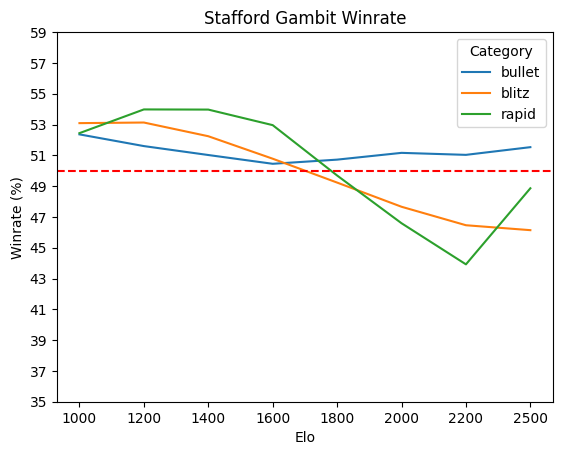

     Elo Category  Winrate (%)
0   1000   bullet        52.36
1   1200   bullet        51.60
2   1400   bullet        51.02
3   1600   bullet        50.45
4   1800   bullet        50.72
5   2000   bullet        51.16
6   2200   bullet        51.03
7   2500   bullet        51.53
8   1000    blitz        53.09
9   1200    blitz        53.13
10  1400    blitz        52.24
11  1600    blitz        50.78
12  1800    blitz        49.23
13  2000    blitz        47.66
14  2200    blitz        46.46
15  2500    blitz        46.14
16  1000    rapid        52.44
17  1200    rapid        53.98
18  1400    rapid        53.97
19  1600    rapid        52.96
20  1800    rapid        49.69
21  2000    rapid        46.59
22  2200    rapid        43.92
23  2500    rapid        48.86


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# make the plot
sns.lineplot(x='Elo', y='Winrate (%)', hue='Category', data=stafford_df)

#label it
plt.xlabel('Elo')
plt.ylabel('Winrate (%)')
plt.title('Stafford Gambit Winrate')
plt.yticks(range(35,61,2))
#fault line to see when gambit is above/below 50% winrate
plt.axhline(y=50,color='red',linestyle='--')

#show the above graph and corresponding data
plt.show()

print(stafford_df)

Stafford - Bullet Evaluation:

* The Stafford gambit has a consistently positive win rate across all Elo ranges.
* The win rate hovers around 51% throughout different Elo levels ; it's consistent.

Stafford - Blitz Evaluation:

* In blitz games, the Stafford gambit exhibits a positive win rate up until 1700 Elo.
* Beyond 1200 Elo, the win rate gradually declines from 53% to around 46% ; this gambit isn't as good against players above 1200 elo.

Stafford - Rapid Evaluation:

* In rapid games, the Stafford gambit maintains a positive win rate until around 1800 Elo.
* Within the Elo range of 1000 to 1600, the win rate fluctuates between approximately 51% and 54%. 
* After 1600 Elo, there is a significant drop to around 44% at 2200 Elo.
* But, the win rate experiences a sharp incline at 2200 Elo and beyond, reaching 49%.

Vienna Gambit

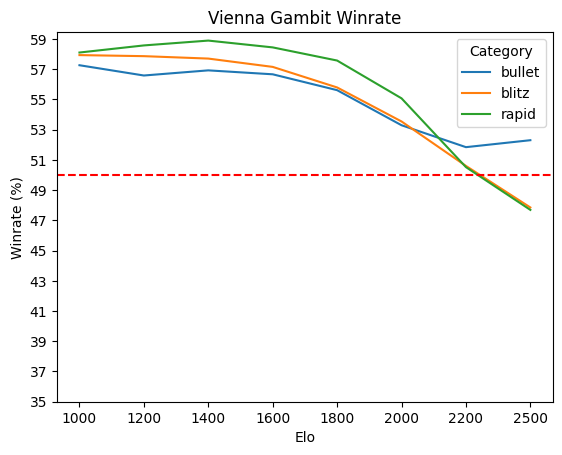

     Elo Category  Winrate (%)
0   1000   bullet        57.26
1   1200   bullet        56.58
2   1400   bullet        56.92
3   1600   bullet        56.66
4   1800   bullet        55.61
5   2000   bullet        53.29
6   2200   bullet        51.84
7   2500   bullet        52.30
8   1000    blitz        57.93
9   1200    blitz        57.86
10  1400    blitz        57.70
11  1600    blitz        57.15
12  1800    blitz        55.79
13  2000    blitz        53.54
14  2200    blitz        50.60
15  2500    blitz        47.85
16  1000    rapid        58.10
17  1200    rapid        58.57
18  1400    rapid        58.89
19  1600    rapid        58.44
20  1800    rapid        57.57
21  2000    rapid        55.07
22  2200    rapid        50.52
23  2500    rapid        47.69


In [ ]:
sns.lineplot(x='Elo', y='Winrate (%)', hue='Category', data=vienna_df)

plt.xlabel('Elo')
plt.ylabel('Winrate (%)')
plt.title('Vienna Gambit Winrate')
plt.yticks(range(35,61,2))
plt.axhline(y=50,color='red',linestyle='--')

plt.show()

print(vienna_df)

Vienna - Bullet Evaluation:

* The Vienna gambit demonstrates a consistently positive win rate across all Elo ranges.
* The win rate tends to fluctuate around 56% within the Elo range of 1000 to 1800. However, it gradually declines to a minimum of 51% at 2200 Elo.

Vienna - Blitz Evaluation:

* In blitz games, the Vienna gambit maintains a positive win rate until approximately 2200 Elo.
* Within the Elo range of 1000 to 1800, the win rate hovers around 57%, showing relatively stable performance. However, as the Elo rating increases, the win rate steadily declines, reaching a minimum of 47% at 2500 Elo.

Vienna - Rapid Evaluation:

* In rapid games, the Vienna gambit maintains a positive win rate until around 2200 Elo.
* Within the Elo range of 1000 to 1800, the win rate fluctuates around 58%, indicating favorable results. However, beyond that range, the win rate declines to a minimum of 47% at 2500 Elo.

Tennison Gambit or as I know it the ICBM (Intercontinental Ballistic Missile) : Elo vs. Winrate(%) in each category

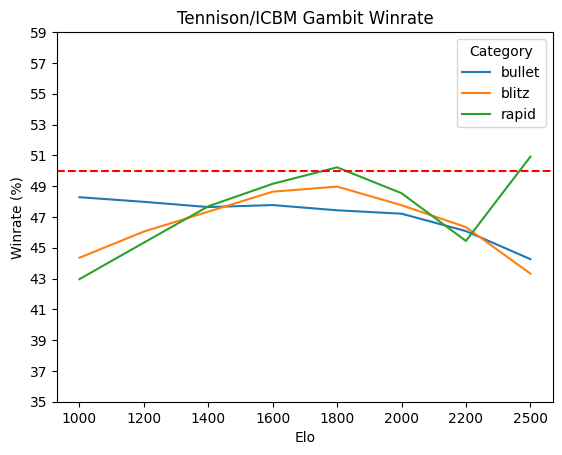

     Elo Category  Winrate (%)
0   1000   bullet        48.28
1   1200   bullet        47.98
2   1400   bullet        47.64
3   1600   bullet        47.77
4   1800   bullet        47.43
5   2000   bullet        47.21
6   2200   bullet        46.08
7   2500   bullet        44.26
8   1000    blitz        44.35
9   1200    blitz        46.05
10  1400    blitz        47.34
11  1600    blitz        48.64
12  1800    blitz        48.97
13  2000    blitz        47.76
14  2200    blitz        46.34
15  2500    blitz        43.32
16  1000    rapid        42.96
17  1200    rapid        45.33
18  1400    rapid        47.69
19  1600    rapid        49.15
20  1800    rapid        50.22
21  2000    rapid        48.54
22  2200    rapid        45.44
23  2500    rapid        50.91


In [ ]:
sns.lineplot(x='Elo', y='Winrate (%)', hue='Category', data=tennison_df)

plt.xlabel('Elo')
plt.ylabel('Winrate (%)')
plt.title('Tennison/ICBM Gambit Winrate')
plt.yticks(range(35,61,2))
plt.axhline(y=50,color='red',linestyle='--')

plt.show()

print(tennison_df)

Tennison - Bullet Evaluation:

* The Tennison gambit consistently maintains a win rate below 50% across all Elo ranges.
* Within the Elo range of 1000 to 2000, the win rate fluctuates around 48%. As the Elo rating surpasses 2000, the win rate decreases further, reaching a minimum of 44% at 2500 Elo.

Tennison - Blitz Evaluation:

* In blitz games, the Tennison gambit sustains a win rate below 50% across all Elo ranges.
* The win rate gradually increases from 44% to 49% within the Elo range of 1000 to 1800. However, it steadily declines thereafter, reaching a minimum of 43% at 2500+ Elo.

Tennison - Rapid Evaluation:

* In rapid games, the Tennison gambit only exhibits a win rate above 50% at Elo ratings of 1800 and 2500.
* Within the Elo range of 1000 to 1800, the win rate rises from 43% to 50%. Then, it gradually decreases to 45% at 2200 Elo before experiencing a sharp rise back to 50% at 2500 Elo.

Jaenisch Gambit : Elo vs. Winrate(%) in each category

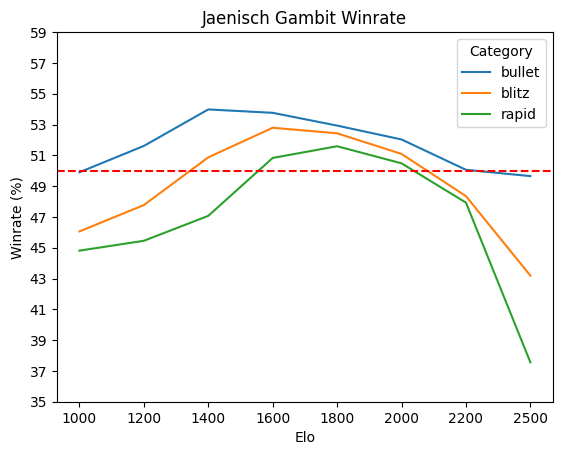

     Elo Category  Winrate (%)
0   1000   bullet        49.90
1   1200   bullet        51.61
2   1400   bullet        53.98
3   1600   bullet        53.76
4   1800   bullet        52.93
5   2000   bullet        52.03
6   2200   bullet        50.06
7   2500   bullet        49.65
8   1000    blitz        46.06
9   1200    blitz        47.77
10  1400    blitz        50.87
11  1600    blitz        52.79
12  1800    blitz        52.43
13  2000    blitz        51.09
14  2200    blitz        48.35
15  2500    blitz        43.19
16  1000    rapid        44.81
17  1200    rapid        45.45
18  1400    rapid        47.07
19  1600    rapid        50.83
20  1800    rapid        51.59
21  2000    rapid        50.48
22  2200    rapid        47.93
23  2500    rapid        37.56


In [ ]:
sns.lineplot(x='Elo', y='Winrate (%)', hue='Category', data=jaenisch_df)

plt.xlabel('Elo')
plt.ylabel('Winrate (%)')
plt.title('Jaenisch Gambit Winrate')
plt.yticks(range(35,61,2))
plt.axhline(y=50,color='red',linestyle='--')

plt.show()

print(jaenisch_df)

Jaenisch - Bullet Evaluation:

* positive win rate across the Elo range of 1000 to 2200. However, as the Elo rating increases from 2200 to 2500, the win rate slightly dips from 50.05% to 49.57%.
* Within the Elo range of 1000 to 1400, the win rate climbs from 50% to 54%. However, beyond that point, it declines to 49.57% at 2500 Elo.

Jaenisch - Blitz Evaluation:

* In blitz games, the Jaenisch gambit maintains a positive win rate within the Elo range of 1400 to 2000.
* Within the Elo range of 1000 to 1600, the win rate climbs from 46% to 52%. However, as the Elo rating increases, it declines to a minimum of 43% at 2500 Elo.

Jaenisch - Rapid Evaluation:

* positive win rate within the Elo range of 1600 to 2000.
* Within the Elo range of 1000 to 1800, the win rate climbs from 45% to 51%. However, it steadily declines to 48% at 2200 Elo and sharply drops to 38% at 2500 Elo.

Gambit Winrates by Category

In [ ]:
#calculate the means of each category grouping in each gambit
#NOTE: mbc = 'mean by category'
vienna_mbc = vienna_df.groupby('Category')['Winrate (%)'].mean().reset_index()
tennison_mbc = tennison_df.groupby('Category')['Winrate (%)'].mean().reset_index()
stafford_mbc = stafford_df.groupby('Category')['Winrate (%)'].mean().reset_index()
jaenisch_mbc = jaenisch_df.groupby('Category')['Winrate (%)'].mean().reset_index()

vienna_mbc['Gambit'] = 'Vienna'
tennison_mbc['Gambit'] = 'Tennison'
stafford_mbc['Gambit'] = 'Stafford'
jaenisch_mbc['Gambit'] = 'Jaenisch'

merged_gambits = pd.concat([vienna_mbc,tennison_mbc,stafford_mbc,jaenisch_mbc],ignore_index=True)

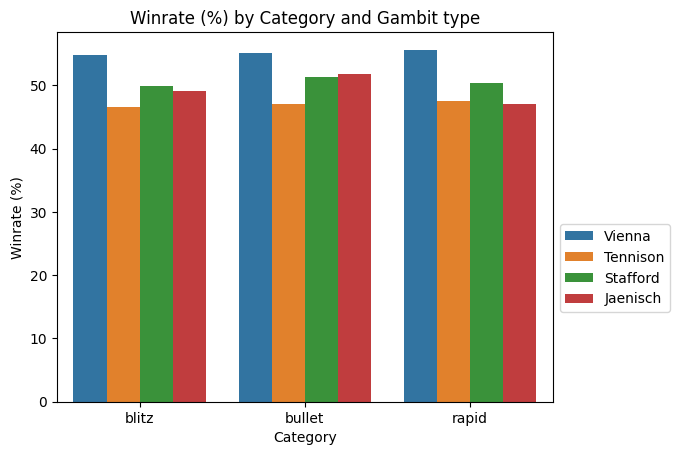

   Category  Winrate (%)    Gambit
0     blitz     54.80250    Vienna
1    bullet     55.05750    Vienna
2     rapid     55.60625    Vienna
3     blitz     46.59625  Tennison
4    bullet     47.08125  Tennison
5     rapid     47.53000  Tennison
6     blitz     49.84125  Stafford
7    bullet     51.23375  Stafford
8     rapid     50.30125  Stafford
9     blitz     49.06875  Jaenisch
10   bullet     51.74000  Jaenisch
11    rapid     46.96500  Jaenisch


In [ ]:
#plot a multi-bar chart that plots the category to the x-axis, winrate to the y-axis
#and each bar being the gambit type.
sns.barplot(x='Category',y='Winrate (%)',hue='Gambit',data=merged_gambits)

plt.title('Winrate (%) by Category and Gambit type')
plt.xlabel('Category')
plt.ylabel('Winrate (%)')
plt.legend(bbox_to_anchor=(1, 0.5))

plt.show()


print(merged_gambits)

#Conclusion



<b>Findings</b>
* Vienna Gambit has the highest average win rate across all categories
  * 54.81% winrate in bullet, 54.81% in blitz and 55.63% in rapid 
* Vienna Gambit's winrate stays above 50% in almost all categories and elos
  * its winrate only drops below 50% in the blitz and rapid categories for elos 2200 and above
* Tennison Gambit has the lowest average winrate across all categories
  * 47.08% win rate in bullet, 46.60% in blitz and 47.42% in rapid, beating the Jaenisch by 0.445%
* Tennison Gambit winrate stays below 50% in almost all categories and elos
  * it has a winrate >= 50% at two elos: 1800 and 2500
* Stafford Gambit has the smallest win rate variance of all gambit-category pairs in the bullet category
  * with a mean winrate of 51.24% and variance of 0.3475






<b>Implications</b>

* The Tennison Gambit is my favourite, given how quickly games can end with it and how intuitive the moves are in the gambit. Given its <= 50% win rate, I should probably look into better gambits for white.
* I'll continue to play the Jaenisch Gambit in bullet at least, given its mostly positive win rate
* I'll continue to play the Stafford in rapid games, as its winrate is positive in my elo range for that category: ~1400. And it is a personal favourite.
* Finally, I'll probably stick with the Vienna no matter the elo or category, given its overall win rate in all categories.










<b>Limitations</b>
* Win rate of certain gambits can be influenced by the activity of the chess community. Focusing on a set of games played by each gambit closer to time of play can give a more accurate result of what winrate to expect.

* The collected data assumes that the opponent accepts the gambit. A more reliable analysis would have a weighted average that considers the frequency of the opponent accepting/rejecting the gambit.






<b>Potential Areas of further investigation</b>

* How the winrate fluctuates as the length of every individual game increases. 
  * For example, an aggresive gambit like the Tennison may have a high winrate in games that last < 15 total moves played. But, a gambit that sets up for counter play later in the game like the Stafford, may have a higher winrate for games that last > 25 total moves played.

* Finding the subsequent opponent's moves that lead to higher win rates. Then, finding the probability that those moves will be played by the opponent based on their elo.
  * In my opinion, a gambit that has a > 90% win rate for a line that is uncommon is less favourable than a gambit that has a 55% to 60% winrate for a line that is played frequently.



<b>Final Remark <
Further analysis is necessary to identify the underlying factors influencing the win rate behavior of each Gambit. Nonetheless, the techniques employed in this project can serve as a starting point for selecting specific openings to investigate based on a player's current elo and preferred category. Of utmost importance is to monitor the fluctuation of win rates for their chosen opening(s) as elo increases, providing insight into the level of in-depth study required.